In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

from DataGenerator import *
from Competition import *
from config import * 
from generic_analyzer import *
from utils.common_helpers import *

In [2]:
BN_EO = initialize_BN()
dataset = BN_EO.simulate(n_samples=50000, seed=SEED)

  0%|          | 0/8 [00:00<?, ?it/s]

In [3]:
C1_label = 'COLLEGE'
C1_features = ['SES', 'SEX', 'SAT', 'SCHOOL']
C1 = Competition(dataset, C1_features, C1_label, ['SEX', 'SES'], [0,0])

In [4]:
C2_label = 'INTERN'
C2_features = ['SES', 'SEX', 'SAT', 'SCHOOL','COLLEGE','CGPA']
C2 = Competition(dataset, C2_features, C2_label, ['SEX', 'SES'], [0,0])

In [5]:
C3_label = 'JOB'
C3_features = ['SES', 'SEX', 'SAT', 'SCHOOL','COLLEGE','CGPA','INTERN']
C3 = Competition(dataset, C2_features, C2_label, ['SEX', 'SES'], [0,0])

In [6]:
X_train, y_train, X_test, y_test, X_val, y_val = C1.create_train_test_val_split(SEED=44)
X_train.shape, X_test.shape, X_val.shape

((30000, 4), (10000, 4), (10000, 4))

In [7]:
# Using the same seed so that all contests share the same split
__ = C2.create_train_test_val_split(SEED=44)
__ = C3.create_train_test_val_split(SEED=44)

In [8]:
best_model = LogisticRegression(C=1, max_iter=200, random_state=SEED, solver='newton-cg')

In [9]:
C1.fit_base_model(best_model)

0.7459

In [10]:
y_preds1 = C1.predict(C1.X_test)
y_probs1 = C1.predict_proba(C1.X_test)

In [11]:
Analyzer = GenericAnalyzer(C1.X_test, C1.y_test, ['SEX','SES'], [0, 0])

for i in Analyzer.test_groups.keys():
    print(i, Analyzer.test_groups[i].shape[0]/Analyzer.X_test.shape[0])

SEX_SES_priv 0.1191
SEX_SES_dis 0.8809
SEX_priv 0.6057
SEX_dis 0.3943
SES_priv 0.2004
SES_dis 0.7996


In [12]:
c1_res = Analyzer.compute_metrics(y_preds1, 'Base_Model')
print(pd.DataFrame(c1_res).to_markdown())

|                |   overall |   SEX_SES_priv |   SEX_SES_dis |   SEX_priv |   SEX_dis |   SES_priv |   SES_dis |
|:---------------|----------:|---------------:|--------------:|-----------:|----------:|-----------:|----------:|
| TPR            |  0.73859  |       1        |      0.654672 |   0.808608 |  0.546512 |  0.955776  |  0.615356 |
| TNR            |  0.751161 |       0        |      0.774331 |   0.616722 |  0.893451 |  0.216769  |  0.800225 |
| PPV            |  0.681137 |       0.853904 |      0.619659 |   0.683949 |  0.669956 |  0.790825  |  0.606945 |
| FNR            |  0.26141  |       0        |      0.345328 |   0.191392 |  0.453488 |  0.0442244 |  0.384644 |
| FPR            |  0.248839 |       1        |      0.225669 |   0.383278 |  0.106549 |  0.783231  |  0.199775 |
| Accuracy       |  0.7459   |       0.853904 |      0.731298 |   0.713885 |  0.79508  |  0.775449  |  0.738494 |
| F1             |  0.708701 |       0.921196 |      0.636685 |   0.741073 |  0.60197  |

In [13]:
def find_q_val(y, alpha):
    n = len(y)
    #alpha_corrected = ((n+1)*(1-alpha))/n
    #pos = int(round(alpha_corrected*n))
    
    q_level = np.ceil((n+1)*(1-alpha))/n
    qhat = np.quantile(y, q_level, interpolation='higher')
    #return np.sort(y)[pos]
    return qhat

In [14]:
C1.predict_proba(Analyzer.X_test)[Analyzer.y_test.shape[0]-1, Analyzer.y_test.values]

array([0.85696259, 0.85696259, 0.14303741, ..., 0.85696259, 0.85696259,
       0.85696259])

In [34]:
alpha = 0.59
q_vals = {}
y_back_fair = {}

y_probs = C1.predict_proba(Analyzer.X_test)[Analyzer.y_test.shape[0]-1, Analyzer.y_test.values]
print("Overall ", find_q_val(y_probs, alpha))

for g in Analyzer.test_groups.keys():
    y_probs = C1.predict_proba(Analyzer.test_groups[g])[Analyzer.test_groups[g].shape[0]-1, Analyzer.y_test[Analyzer.test_groups[g].index].values]
    q_vals[g] = find_q_val(y_probs, alpha)
    y_back_fair[g] = np.array([int(y__ > q_vals[g]) for y__ in y_probs])
    
    print(g, q_vals[g])
    

Overall  0.14303741072847553
SEX_SES_priv 0.8982061694428987
SEX_SES_dis 0.8569625892715245
SEX_priv 0.14303741072847553
SEX_dis 0.8303263027211945
SES_priv 0.8982061694428987
SES_dis 0.8569625892715245


In [16]:
interventions = {
    "SEX": ['SEX_priv', 'SEX_dis'],
    "SES": ['SES_priv', 'SES_dis'],
    "SEX_SES" : ['SEX_SES_priv', 'SEX_SES_dis']
}

In [17]:
y_preds_back = {}

for level in interventions:
    y_preds_back[level] = pd.DataFrame({}, columns = Analyzer.X_test.columns)

    for g in interventions[level]:
        temp = Analyzer.test_groups[g].copy(deep=True)
        temp["y_fair"] = y_back_fair[g]
        y_preds_back[level] = y_preds_back[level].append(temp)

In [18]:
y_preds_back['SEX'].shape, y_preds_back['SES'].shape, y_preds_back['SEX_SES'].shape, Analyzer.X_test.shape

((10000, 5), (10000, 5), (10000, 5), (10000, 4))

In [19]:
y_preds_back['Control'] = {'y_fair' : pd.Series(y_preds1)}

In [20]:
res_df = {}
for i in y_preds_back.keys():
    res_df[i] = Analyzer.compute_metrics(y_preds_back[i]['y_fair'].values, i)
    print(i)
    print(pd.DataFrame(res_df[i]).to_markdown())
    print("   \n")

SEX
|                |   overall |   SEX_SES_priv |   SEX_SES_dis |   SEX_priv |   SEX_dis |   SES_priv |   SES_dis |
|:---------------|----------:|---------------:|--------------:|-----------:|----------:|-----------:|----------:|
| TPR            |  0.701314 |       0.716814 |      0.696338 |   0.698402 |  0.709302 |   0.712211 |  0.695131 |
| TNR            |  0.299226 |       0.356322 |      0.297465 |   0.308027 |  0.289912 |   0.308793 |  0.298348 |
| PPV            |  0.418688 |       0.866825 |      0.357594 |   0.508668 |  0.283315 |   0.761468 |  0.331843 |
| FNR            |  0.298686 |       0.283186 |      0.303662 |   0.301598 |  0.290698 |   0.287789 |  0.304869 |
| FPR            |  0.700774 |       0.643678 |      0.702535 |   0.691973 |  0.710088 |   0.691207 |  0.701652 |
| Accuracy       |  0.4675   |       0.664148 |      0.440913 |   0.505696 |  0.408826 |   0.613772 |  0.43084  |
| F1             |  0.524341 |       0.784715 |      0.472529 |   0.588623 |  0.4049

In [21]:
res_df.keys()

dict_keys(['SEX', 'SES', 'SEX_SES', 'Control'])

In [22]:
res_df['SEX']['overall'].keys()

dict_keys(['TPR', 'TNR', 'PPV', 'FNR', 'FPR', 'Accuracy', 'F1', 'Selection-Rate', 'Positive-Rate'])

In [23]:
def get_res_as_list(res_df, intervention, test_group, metric_name):
    return res_df[intervention][test_group][metric_name]

In [24]:
interventions

{'SEX': ['SEX_priv', 'SEX_dis'],
 'SES': ['SES_priv', 'SES_dis'],
 'SEX_SES': ['SEX_SES_priv', 'SEX_SES_dis']}

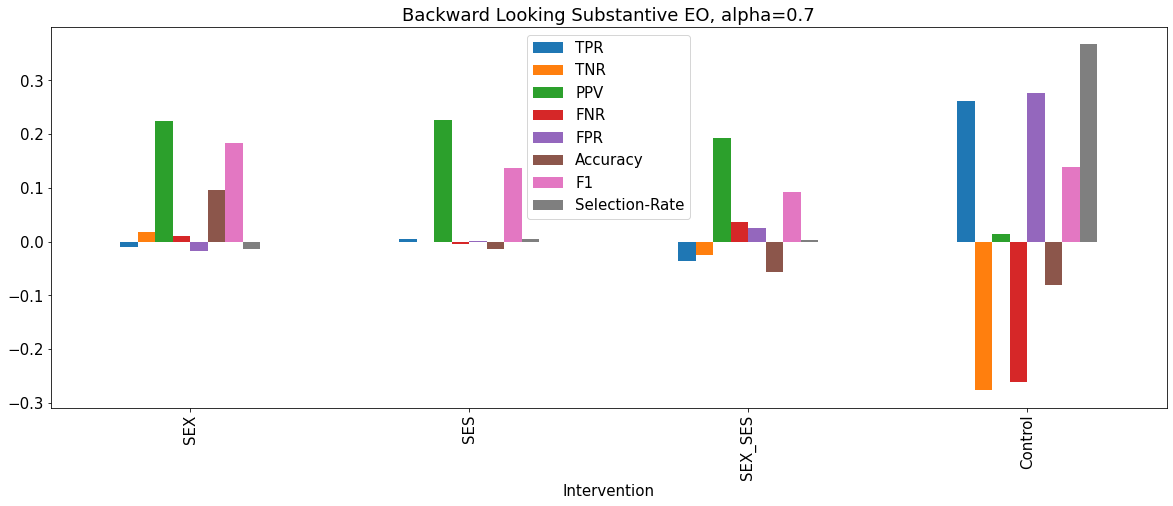

In [25]:
temp = pd.DataFrame({})
for m in ['TPR', 'TNR', 'PPV', 'FNR', 'FPR', 'Accuracy', 'F1', 'Selection-Rate']: 
#for m in ['TPR', 'TNR', 'PPV', 'FNR', 'FPR', 'Accuracy', 'F1', 'Selection-Rate', 'Positive-Rate']: 
    #res_m = [get_res_as_list(res_df, i, 'overall', m) for i in res_df.keys()]
    res_priv = [get_res_as_list(res_df, i, 'SEX_priv', m) for i in res_df.keys()]
    res_dis = [get_res_as_list(res_df, i, 'SEX_dis', m) for i in res_df.keys()]
    res_m = np.subtract(res_priv,res_dis)
    #print(res_m)
    temp[m] = np.array(res_m).astype(float)
    temp["Intervention"] = list(res_df.keys())
    
plt.rcParams["figure.figsize"] = (20, 7)
plt.rcParams["font.size"] = 15
#temp.plot.bar(x="Intervention", title="Backward Looking Substantive EO, alpha="+str(alpha), ylim=(0,2))
temp.plot.bar(x="Intervention", title="Backward Looking Substantive EO, alpha="+str(alpha))
    
plt.show()   

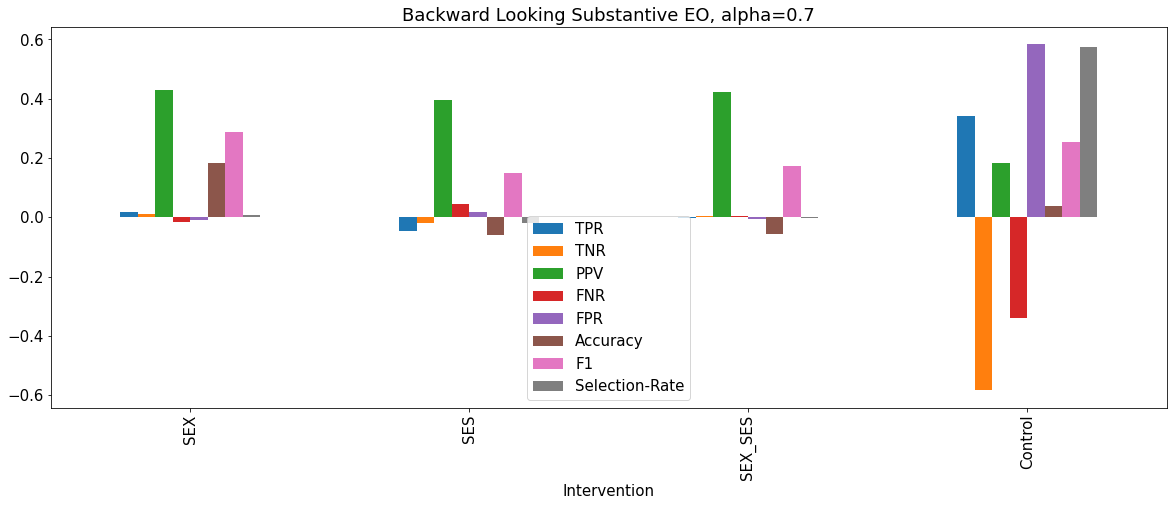

In [26]:
temp = pd.DataFrame({})
for m in ['TPR', 'TNR', 'PPV', 'FNR', 'FPR', 'Accuracy', 'F1', 'Selection-Rate']: 
#for m in ['TPR', 'TNR', 'PPV', 'FNR', 'FPR', 'Accuracy', 'F1', 'Selection-Rate', 'Positive-Rate']: 
    #res_m = [get_res_as_list(res_df, i, 'overall', m) for i in res_df.keys()]
    res_priv = [get_res_as_list(res_df, i, 'SES_priv', m) for i in res_df.keys()]
    res_dis = [get_res_as_list(res_df, i, 'SES_dis', m) for i in res_df.keys()]
    res_m = np.subtract(res_priv,res_dis)
    #print(res_m)
    temp[m] = np.array(res_m).astype(float)
    temp["Intervention"] = list(res_df.keys())
    
plt.rcParams["figure.figsize"] = (20, 7)
plt.rcParams["font.size"] = 15
#temp.plot.bar(x="Intervention", title="Backward Looking Substantive EO, alpha="+str(alpha), ylim=(0,2))
temp.plot.bar(x="Intervention", title="Backward Looking Substantive EO, alpha="+str(alpha))
    
plt.show()   

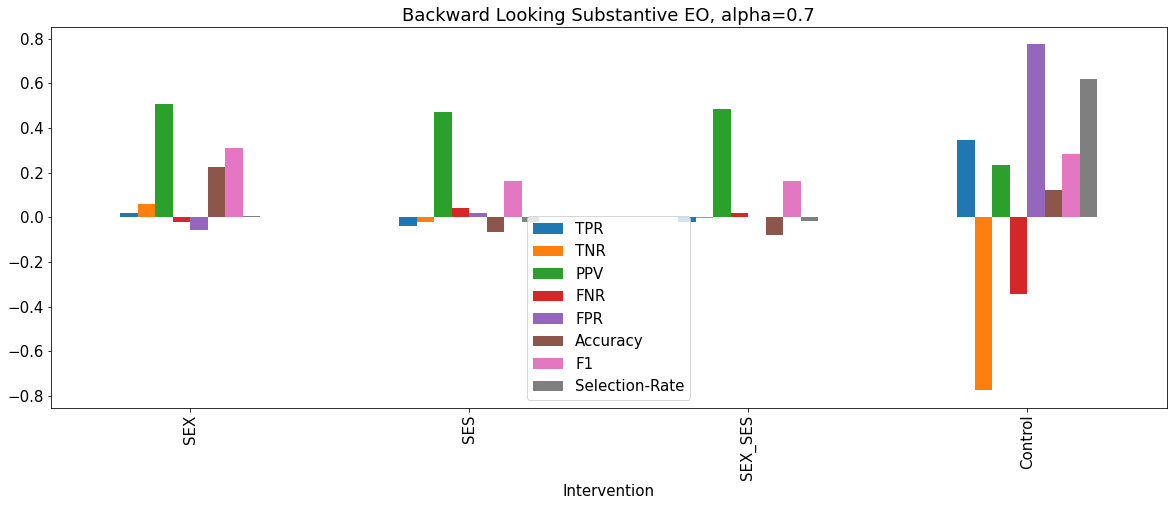

In [27]:
temp = pd.DataFrame({})
for m in ['TPR', 'TNR', 'PPV', 'FNR', 'FPR', 'Accuracy', 'F1', 'Selection-Rate']: 
#for m in ['TPR', 'TNR', 'PPV', 'FNR', 'FPR', 'Accuracy', 'F1', 'Selection-Rate', 'Positive-Rate']: 
    #res_m = [get_res_as_list(res_df, i, 'overall', m) for i in res_df.keys()]
    res_priv = [get_res_as_list(res_df, i, 'SEX_SES_priv', m) for i in res_df.keys()]
    res_dis = [get_res_as_list(res_df, i, 'SEX_SES_dis', m) for i in res_df.keys()]
    res_m = np.subtract(res_priv,res_dis)
    #print(res_m)
    temp[m] = np.array(res_m).astype(float)
    temp["Intervention"] = list(res_df.keys())
    
plt.rcParams["figure.figsize"] = (20, 7)
plt.rcParams["font.size"] = 15
#temp.plot.bar(x="Intervention", title="Backward Looking Substantive EO, alpha="+str(alpha), ylim=(0,2))
temp.plot.bar(x="Intervention", title="Backward Looking Substantive EO, alpha="+str(alpha))
    
plt.show()   

In [28]:
cal_scores = 1-cal_smx[np.arange(n),cal_labels]
# 2: get adjusted quantile
q_level = np.ceil((n+1)*(1-alpha))/n
qhat = np.quantile(cal_scores, q_level, interpolation='higher')
prediction_sets = val_smx >= (1-qhat) # 3: form prediction sets

NameError: name 'cal_smx' is not defined

In [ ]:
Analyzer.y_test.value_counts()